In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:

NUM_FOLD = 5

df = pd.read_csv('../dataset/train.csv', index_col='id')
# train = pd.read_csv('../dataset/train.csv', index_col='id')
# test = pd.read_csv('../dataset/test.csv', index_col='id')
# original = pd.read_csv('../dataset/original.csv')
# sample_submission = pd.read_csv('../dataset/sample_submission.csv')


In [3]:

# # accepted_cols = ['person_income', 'person_home_ownership', 'loan_intent',
# #        'loan_grade', 'loan_int_rate', 'loan_percent_income','loan_status']

# # train = train[accepted_cols]
# # original = original[accepted_cols]
# # accepted_cols.remove("loan_status")
# # test = test[accepted_cols]



# cat_cols = list(test.select_dtypes(include=['object']).columns)

# for df in [train, test, original]:
#     for col in cat_cols:
#         df[col] = df[col].astype('str').astype('category')


# X = train.drop(['loan_status'], axis=1)
# y = train['loan_status']
# X_original = original.drop(['loan_status'], axis=1)
# y_original = original['loan_status']





In [5]:
# df['log_person_income'] = np.log1p(df['person_income'])

# ceil all float columns to int

for col in df.select_dtypes(include=['float']).columns:
    df[col] = np.ceil(df[col]).astype(int)
    


<Axes: xlabel='loan_status', ylabel='log_person_income'>

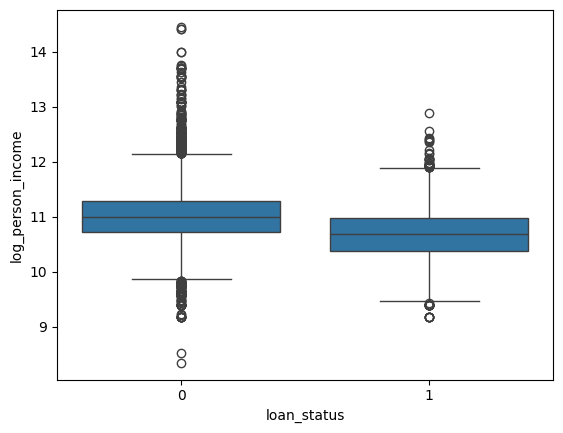

In [6]:
import seaborn as sns

sns.boxplot(x='loan_status', y='log_person_income', data=df)

<Axes: xlabel='log_person_income', ylabel='Count'>

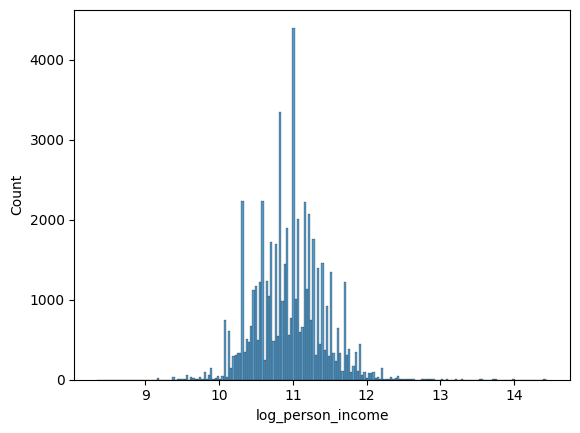

In [7]:
sns.histplot(df['log_person_income'])

int64
int64
object
float64
object
object
int64
float64
float64
object
int64
int64
float64


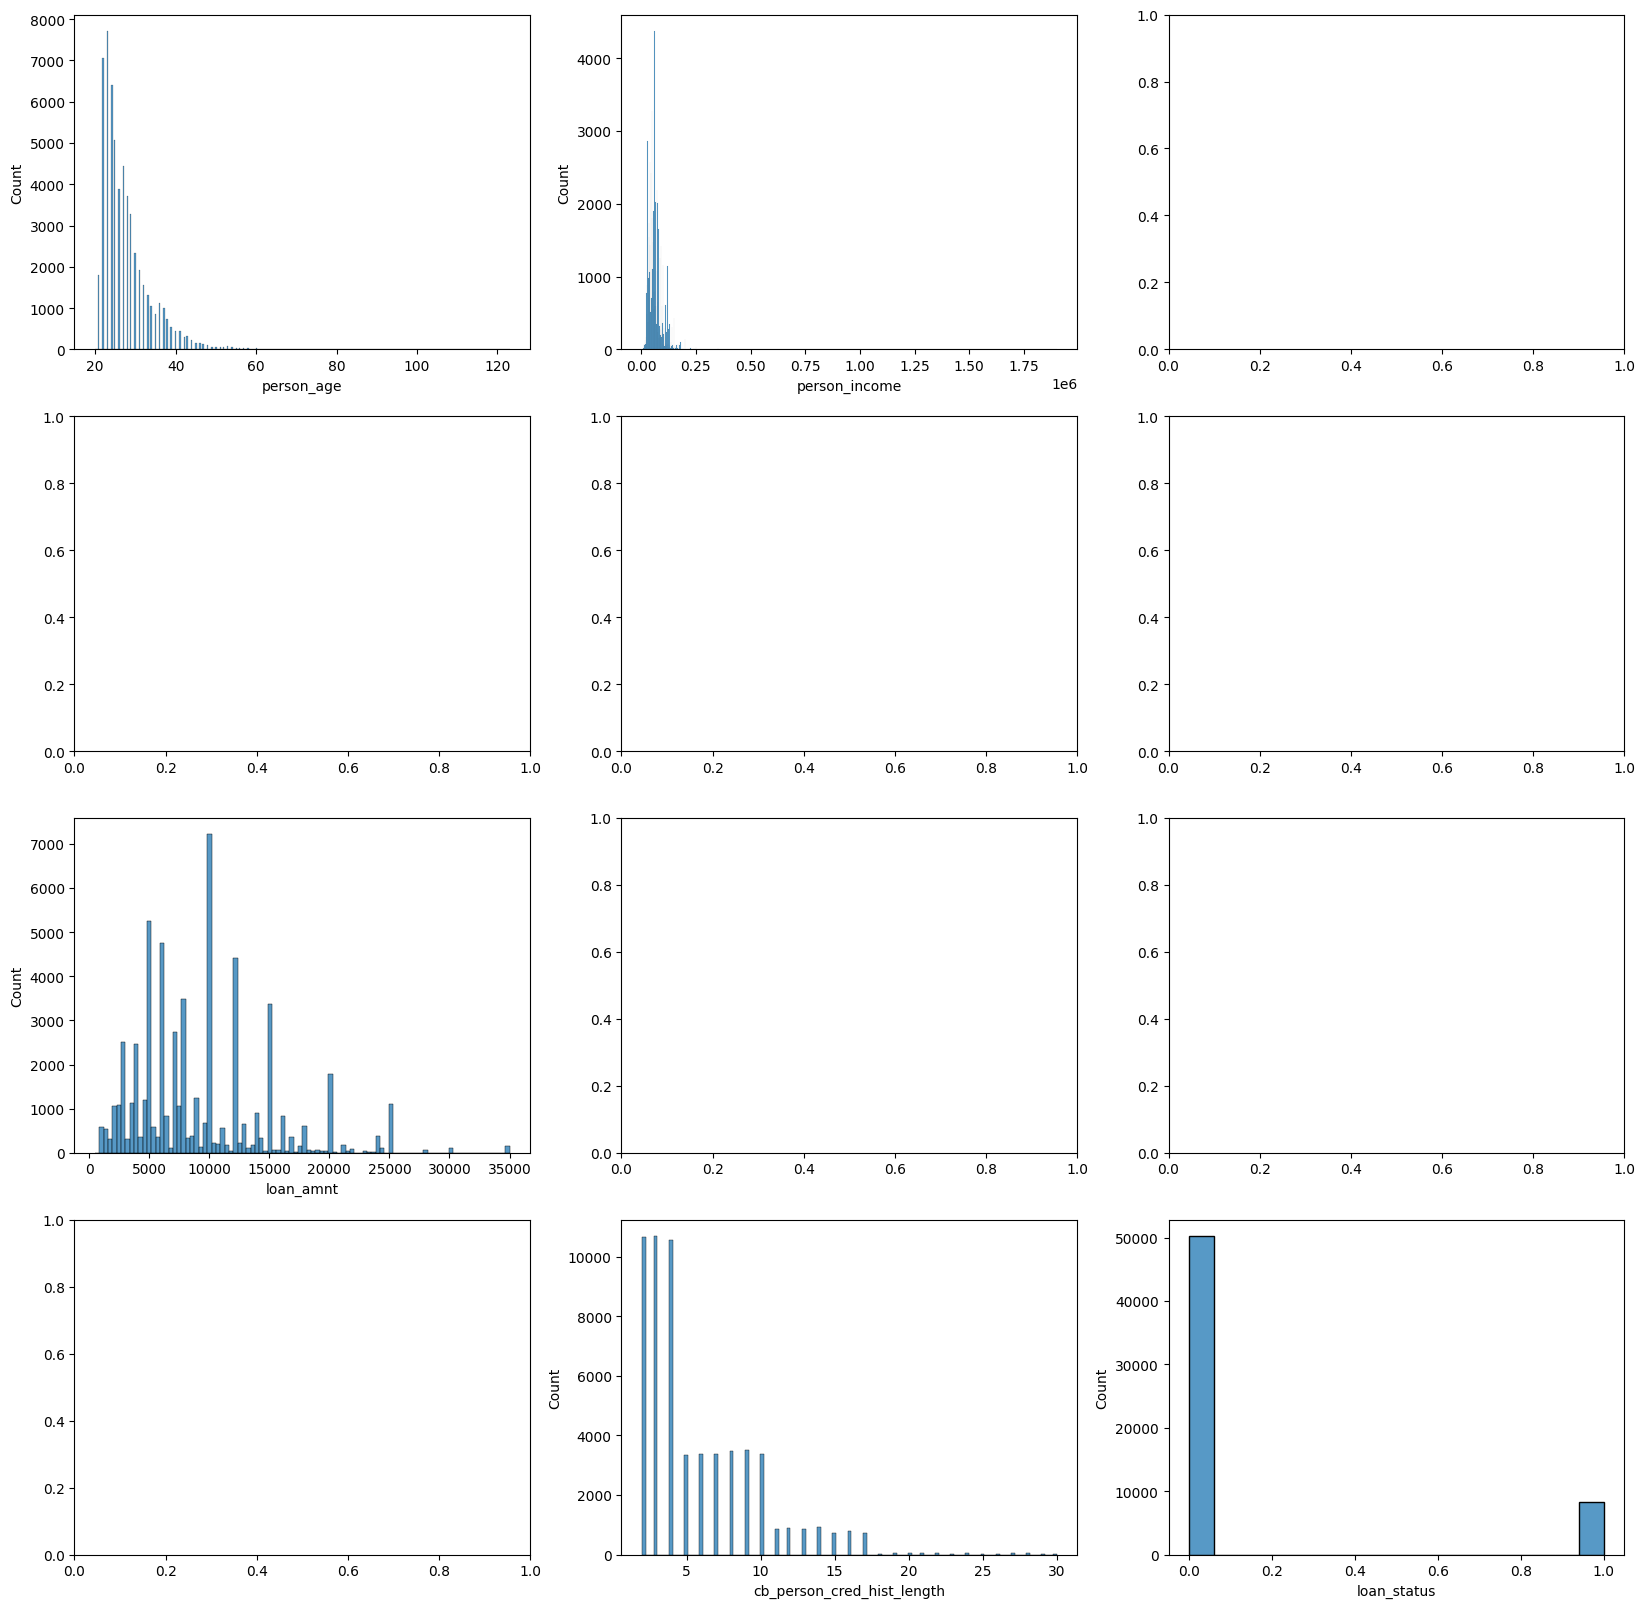

In [12]:
# for col in df.columns:
#     if df[col].dtype != 'object':
#         sns.histplot(df[col])

# draw hist diagram in subplots for each numerical column
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
for i, col in enumerate(df.columns):
    print(df[col].dtype)
    if df[col].dtype == 'int64' :
        sns.histplot(df[col], ax=axes[i//3, i%3])